1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to graphically display the regions.
* Use `scipy.optimize.minimize()`, trying its optional arguments.

C:\Users\rezvan\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


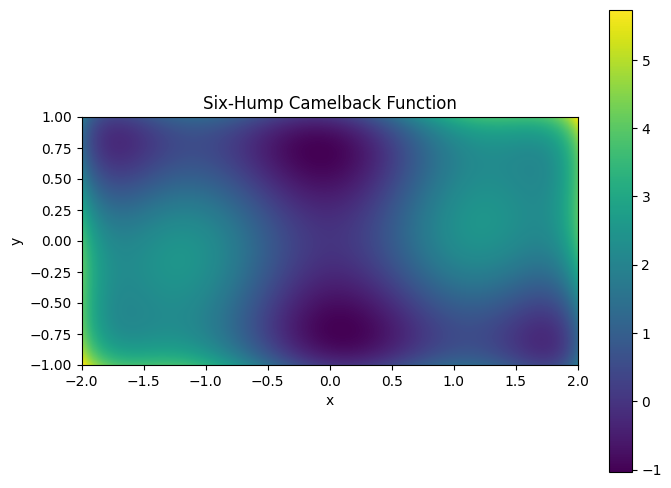

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.0
        x: [ 0.000e+00  0.000e+00]
      nit: 0
      jac: [ 5.960e-08 -5.960e-08]
 hess_inv: [[1 0]
            [0 1]]
     nfev: 3
     njev: 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define the function
def camelback_function(x):
    return (4 - 2.1*x[0]**2 + x[0]**4/3)*x[0]**2 + x[0]*x[1] + (4*x[1]**2 - 4)*x[1]**2

# Grid for visualization
x = np.linspace(-2, 2, 400)
y = np.linspace(-1, 1, 400)
X, Y = np.meshgrid(x, y)
Z = camelback_function([X, Y])

# Visualization
plt.figure(figsize=(8, 6))
plt.imshow(Z, extent=[-2, 2, -1, 1], origin='lower')
plt.colorbar()
plt.title('Six-Hump Camelback Function')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Minimization
initial_guess = [0, 0]
result = minimize(camelback_function, initial_guess)
result


2\. **Non-linear ODE: the damped pendulum**

The equation of the motion of a forced pendulum, as a function of the angle $\theta$ with the vertical, is given by:

$$\frac{d^2\theta}{dt^2} = -\frac{1}{Q} \frac{d\theta}{dt} + \frac{g}{l}\sin\theta + d \cos\Omega t$$

where $t$ is time, $Q$ is the damping factor, $d$ is the forcing amplitude, and $\Omega$ is the driving frequency of the forcing. 

This second order ODE needs to be written as two coupled first order ODEs by defining a new variable $\omega \equiv d\theta/dt$:

$$\frac{d\theta}{dt} = \omega$$
$$\frac{d\omega}{dt} = -\frac{1}{Q}\,\omega + \frac{g}{l}\sin\theta + d \cos\Omega t$$

Consider the initial conditions $\theta_0 = \omega_0 = 0$, and $l = 10$, $Q = 2.0$, $d = 1.5$, and $\omega = 0.65$.

 - Solve the ODE with `odeint` over a period of 200 time steps
 - Create two plots, one of $\theta$ as a function of the time, and $\omega$ as a function of the time
 - **Optional**: determine if there is a set of parameters for which the motion is chaotic.

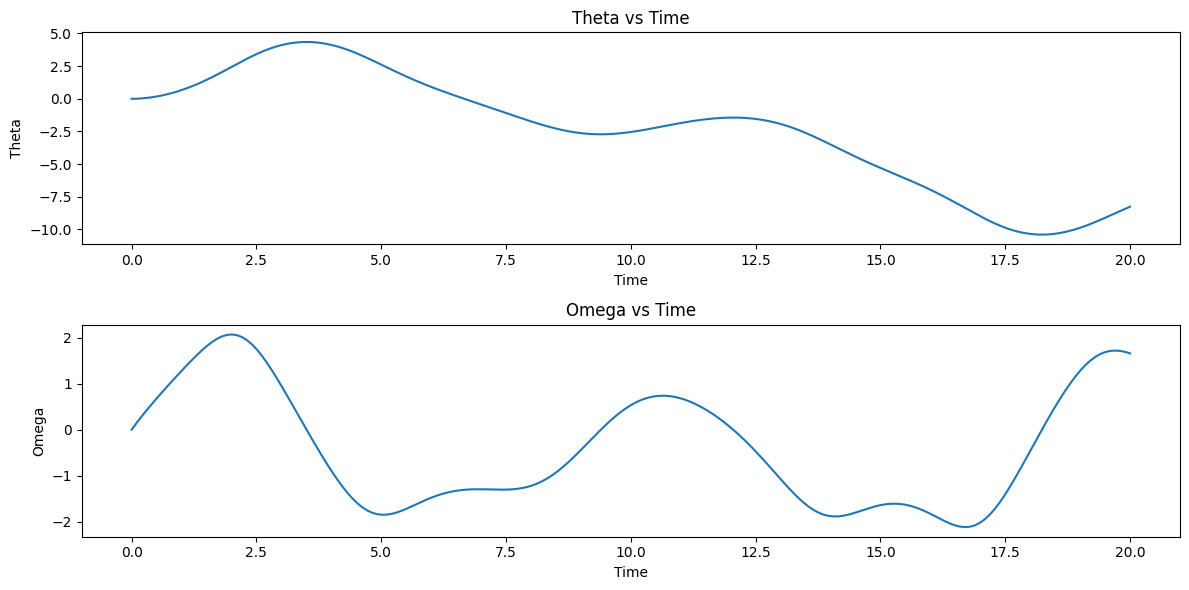

In [2]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the ODE system
def pendulum_system(state, t, Q, g, l, d, Omega):
    theta, omega = state
    dtheta_dt = omega
    domega_dt = -omega/Q + g/l*np.sin(theta) + d*np.cos(Omega*t)
    return [dtheta_dt, domega_dt]

# Parameters
Q = 2.0
g = 9.81  # Acceleration due to gravity
l = 10
d = 1.5
Omega = 0.65
t = np.linspace(0, 20, 200)  # Time array

# Initial conditions
theta0 = 0
omega0 = 0
initial_conditions = [theta0, omega0]

# Solve the ODE
solution = odeint(pendulum_system, initial_conditions, t, args=(Q, g, l, d, Omega))

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, solution[:, 0])
plt.title('Theta vs Time')
plt.xlabel('Time')
plt.ylabel('Theta')

plt.subplot(2, 1, 2)
plt.plot(t, solution[:, 1])
plt.title('Omega vs Time')
plt.xlabel('Time')
plt.ylabel('Omega')

plt.tight_layout()
plt.show()


3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

The dataset is the one downloaded at the beginning of Lecture 06:

 - `!wget https://www.dropbox.com/s/ebe1cnyd2gm836a/populations.txt -P data/`

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
url = 'https://www.dropbox.com/s/ebe1cnyd2gm836a/populations.txt'
data = pd.read_csv(url, sep='\t')

# FFT analysis
hare_population = data['Hare']
fft_hare = np.fft.fft(hare_population)
frequencies = np.fft.fftfreq(len(hare_population))

# Plotting the FFT
plt.figure(figsize=(8, 6))
plt.plot(frequencies, np.abs(fft_hare))
plt.title('FFT of Hare Population')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()


ValueError: complex() arg is a malformed string

   # year     hare     lynx  carrot
0    1900  30000.0   4000.0   48300
1    1901  47200.0   6100.0   48200
2    1902  70200.0   9800.0   41500
3    1903  77400.0  35200.0   38200
4    1904  36300.0  59400.0   40600


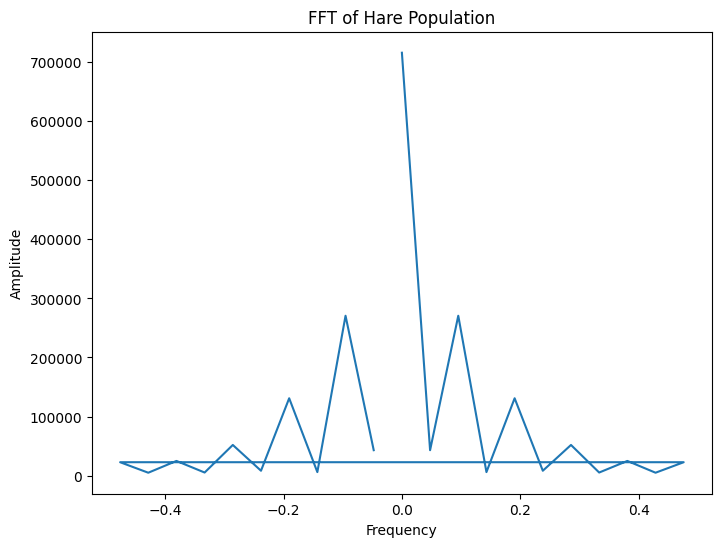

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Replace this with the path to your file
file_path = './populations.txt'

# Load the dataset
# Adjust the 'sep' parameter as needed, e.g., sep=',' for CSV files
data = pd.read_csv(file_path, sep='\t')
print(data.head())
# FFT analysis
hare_population = data['hare']
fft_hare = np.fft.fft(hare_population)
frequencies = np.fft.fftfreq(len(hare_population))

# Plotting the FFT
plt.figure(figsize=(8, 6))
plt.plot(frequencies, np.abs(fft_hare))
plt.title('FFT of Hare Population')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()


4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("images/moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the 2D regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.

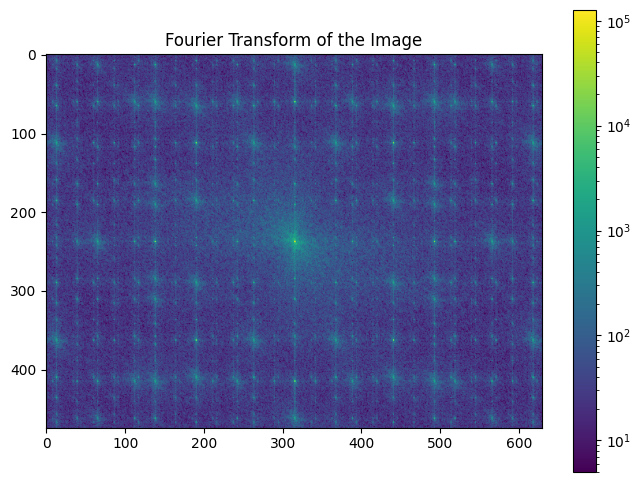

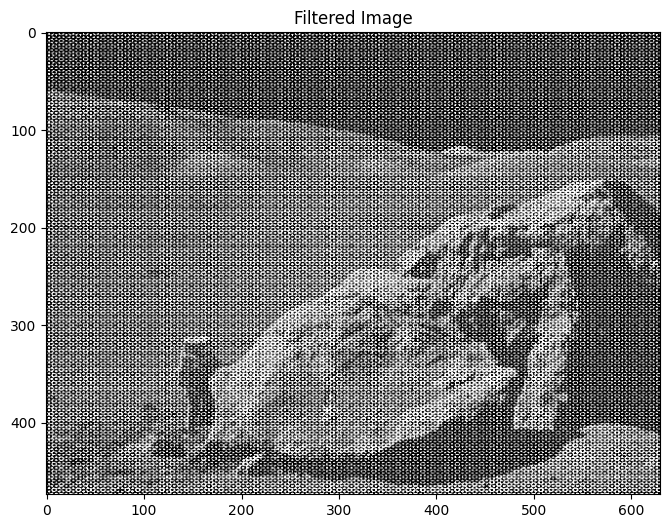

In [5]:
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2, fftshift
from matplotlib.colors import LogNorm

# Load the image
image = plt.imread("./images/moonlanding.png")

# Perform 2D FFT
fft_image = fft2(image)
fft_image_shifted = fftshift(fft_image)

# Plot the spectrum
plt.figure(figsize=(8, 6))
plt.imshow(np.abs(fft_image_shifted), norm=LogNorm(vmin=5))
plt.colorbar()
plt.title('Fourier Transform of the Image')
plt.show()

# Noise removal (this part requires specific knowledge of the noise pattern)
# Example: fft_image_shifted[noise_region] = 0

# Inverse FFT to get the filtered image
filtered_image = ifft2(fft_image_shifted)

# Plot the filtered image
plt.figure(figsize=(8, 6))
plt.imshow(np.abs(filtered_image), cmap='gray')
plt.title('Filtered Image')
plt.show()
